In [1]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Input, Conv2D, Flatten, LeakyReLU, Dropout, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:
# Load dữ liệu mnist
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

In [2]:
# plot images from the training dataset
def _plot(X, iteration):
    for i in range(25):
        # define subplot
        plt.subplot(5, 5, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(X[i], cmap='gray_r')
    plt.savefig(str(iteration) + ".png")


In [3]:

def _discriminator():
    # Khai báo các layers
    inpt = Input(shape=(28, 28, 1))
    conv1 = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same')(inpt)
    act_leak1 = LeakyReLU(alpha=0.3)(conv1)
    dropout = Dropout(0.4)(act_leak1)
    conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same')(dropout)
    act_leak2 = LeakyReLU(alpha=0.3)(conv2)
    flat = Flatten()(act_leak2)
    den = Dense(1, activation='sigmoid')(flat)
     # Khởi tạo model
    model = Model(inputs = [inpt], outputs = [den])
    # Compile với optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

discriminator = _discriminator()
plot_model(discriminator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


2023-05-20 20:21:02.707436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 20:21:02.712213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 20:21:02.712390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 20:21:02.712958: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
from tensorflow.keras.layers import Conv2DTranspose

def _generator(noise_size = 100):
    n_units = 64*7*7
    inpt = Input(shape=(noise_size))
    den1 = Dense(n_units)(inpt)
    act_leak1 = LeakyReLU(alpha=0.3)(den1)
    reshape = Reshape((7,7,64))(act_leak1)
    con2DTran1 = Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same')(reshape)
    act_leak2 = LeakyReLU(alpha=0.3)(con2DTran1)
    con2DTran2 = Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same')(act_leak2)
    act_leak3 = LeakyReLU(alpha=0.3)(con2DTran2)
    con = Conv2D(filters=1, kernel_size=(28, 28), activation='sigmoid', padding='same')(act_leak3)

    # Khởi tạo model
    model = Model(inputs = [inpt], outputs = [con])
    # Compile với optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

generator = _generator(noise_size = 100)
plot_model(generator, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


/home/innovation2060/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
from tensorflow.keras.models import Sequential

def _gan(g_model, d_model):
  # Đóng băng weight của discriminator
    d_model.trainable = False
    # Khởi tạo model GAN
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Khai báo số chiều của noise véc tơ input của generator.
latent_dim = 100
# Khởi tạo discriminator và generatator model
d_model = _discriminator()
g_model = _generator(latent_dim)
# Khởi tạo GAN model
gan_model = _gan(g_model, d_model)
plot_model(gan_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


/home/innovation2060/anaconda3/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
def _normalize():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

In [7]:
import numpy as np

# Hàm sinh batch input là noise véc tơ cho generator
def generate_latent_points(latent_dim, n_samples):
    # khởi tạo input ngẫu nhiên
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape về batch
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 

# Hàm sinh batch cho fake sample, nhãn của fake sample là 0
def generate_fake_samples(g_model, latent_dim, n_samples):
    # sinh batch là các noise véc tơ
    x_input = generate_latent_points(latent_dim, n_samples)
    # dự báo outputs từ g_model
    X = g_model.predict(x_input)
    # khởi tạo y = 0 với nhãn fake
    y = np.zeros((n_samples, 1))
    return X, y

In [8]:
def generate_real_samples(dataset, n_samples):
    # lựa chọn index ngẫu nhiên để lựa chọn batch
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # trích suất các ảnh từ dataset
    X = dataset[ix]
    # khởi tạo y = 1 với nhãn real
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
# đánh giá accuracy của discriminator trên cả tập real và tập fake
def summarize_performance(epoch, gan_model, X_real, y_real, X_fake, y_fake):
    _, acc_real = gan_model.layers[1].evaluate(X_real, y_real, verbose=0)
    _, acc_fake = gan_model.layers[1].evaluate(X_fake, y_fake, verbose=0)
    # thống kê discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))


In [10]:
import tensorflow as tf

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256, k=2):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # Huấn luyện mô hình trên các epochs
    with tf.device('/GPU:0'):
        for i in range(n_epochs):
            if i % 5 == 0:
                print('Epoch ', str(i))
            for j in range(bat_per_epo):
                if j % k == 0:
                    # Step 1: Huấn luyện trên discriminator
                    gan_model.layers[0].trainable = False
                    gan_model.layers[1].trainable = True
                    # Khởi tạo batch huấn luyện trong đó có 1/2 batch là real và 1/2 batch là fake
                    X_real, y_real = generate_real_samples(dataset, half_batch)
                    X_fake, y_fake = generate_fake_samples(gan_model.layers[0], latent_dim, half_batch)
                    X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                    d_loss, _ = gan_model.layers[1].train_on_batch(X, y)
#                     print('>%d, %d/%d, d=%.3f' % (i+1, j+1, bat_per_epo, d_loss))
      
                # Step 2: Huấn luyện trên generator
                # Khởi tạo batch noise
                X_gan = generate_latent_points(latent_dim, n_batch)
                # Những dữ liệu noise này giả định là đã đánh lừa được discriminator nên được gán nhãn là 1
                y_gan = np.ones((n_batch, 1))
                # huấn luyện generator thông qua gan_model
                gan_model.layers[0].trainable = True
                gan_model.layers[1].trainable = False
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
                # Loss function trên discriminator, generator
#                 print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
                # Đánh giá mô hình:
                # summarize_performance(j, gan_model, X_real, y_real, X_fake, y_fake)  
            if i % 5 == 0:
                X_eval, y_eval = generate_fake_samples(g_model=gan_model.layers[0], latent_dim=100, n_samples=25)
                _plot(X_eval[:, :, :, 0], i)

Epoch  0


2023-05-20 20:21:04.638984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2023-05-20 20:21:05.221275: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-20 20:21:45.522108: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch  5
Epoch  10
Epoch  15
Epoch  20
Epoch  25
Epoch  30
Epoch  35
Epoch  40
Epoch  45
Epoch  50
Epoch  55
Epoch  60
Epoch  65
Epoch  70
Epoch  75
Epoch  80
Epoch  85
Epoch  90
Epoch  95
Epoch  100
Epoch  105
Epoch  110
Epoch  115
Epoch  120
Epoch  125
Epoch  130
Epoch  135
Epoch  140
Epoch  145
Epoch  150
Epoch  155
Epoch  160
Epoch  165
Epoch  170
Epoch  175
Epoch  180
Epoch  185
Epoch  190
Epoch  195


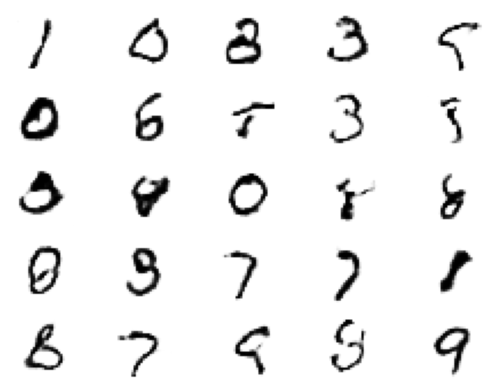

In [12]:
# train model
dataset = _normalize()
train(g_model, d_model, gan_model, dataset, latent_dim)


In [15]:
gan_model.save('gan_mnist.h5')
